# Adaptive PDE discretizations on Cartesian grids
## Volume : Algorithmic tools
## Part : Tensor decomposition techniques
## Chapter : Voronoi's reduction, in dimension 6, application to Hooke tensor decomposition

We rely on Voronoi's first reduction of quadratic forms to decompose symmetric positive definite matrices in dimension $\leq 6$, in a form which resembles the eigenvalue-eigenvector decomposition but with integer offsets:
$$
    D = \sum_{1 \leq i \leq d'} \rho_i e_i e_i^T
$$
where $d'=d(d+1)/2$ (except $d'=12$ in dimension $4$ in our implementation), $\rho_i\geq 0$, and $e_i \in Z^d$.

The six-dimensional case is especially interesting for its applications to the [Hooke elasticity tensor in three dimensional elasticity](../Notebooks_Div/ElasticEnergy.ipynb). The approach is (very) unlikely to extend to higher dimensions (including dimension 7), in a computationally efficient manner, due to a combinatorial explosion in Voronoi's theory.

**Note on excecuting this notebook.**
The implementation of Voronoi's decomposition involves a rather large data file, which is not included in the agd library, but provided in the AdaptiveGridDiscretizations repository (File `Miscellaneous/Geometry6_data2.h`). Executing this notebook thus requires a bit more effort than the others.

<!---
The quadratic form defined by the Hooke tensor is reformulated, using Voronoi's decomposition, in the form
$$
    \sum_{1 \leq i \leq d'} \rho_i \mathrm{Tr}(M D_i)^2
$$
where $d'=21$, $\rho_i\geq 0$, $D_i$ is a $3 \times 3$ symmetric matrix with integer entries.

The matrices $D_i$ usually have rather small entries within $-2,...,2$, since the the Hooke tensor associated with physical materials is not too large.
--->

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Computing the decomposition of a tensor](#1.-Computing-the-decomposition-of-a-tensor)
    * [1.1 Case of a $6\times 6$ tensor](#1.1-Case-of-a-$6\times-6$-tensor)
    * [1.2 A family of tensors](#1.2-A-family-of-tensors)
    * [1.3 Case of a field of tensors](#1.3-Case-of-a-field-of-tensors)
  * [2. Under the hood, Voronoi's first reduction](#2.-Under-the-hood,-Voronoi's-first-reduction)
    * [2.1 Voronoi's perfect forms](#2.1-Voronoi's-perfect-forms)
    * [2.2 Computing Voronoi's first reduction](#2.2-Computing-Voronoi's-first-reduction)
    * [2.3 Most common optimal form](#2.3-Most-common-optimal-form)
  * [3. Voronoi's first reduction in lower dimensions](#3.-Voronoi's-first-reduction-in-lower-dimensions)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('TensorVoronoi6','Algo'))

In [2]:
from agd import LinearParallel as lp
from agd.Selling import GatherByOffset
from agd import AutomaticDifferentiation as ad
from agd.Metrics import Seismic
from agd.Plotting import savefig; #savefig.dirName = 'Figures/TensorVoronoi'
from agd.Metrics.misc import flatten_symmetric_matrix, expand_symmetric_matrix

The routines for tensor decomposition are for efficiency purposes provided in a small c++ library, named FileVDQ where VDQ stands for "Voronoi Decomposition of Quadratic forms". This is in contrast with the two and three dimensional cases, where the decomposition algorithm is coded in Python (the c++ library can also be used in smaller dimensions). A function named `VoronoiDecomposition` provides the interface.

In [3]:
from agd.Eikonal import VoronoiDecomposition

In [4]:
import numpy as np; allclose = np.allclose
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [5]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global expand_symmetric_matrix,VoronoiDecomposition
    expand_symmetric_matrix,VoronoiDecomposition = rreload([expand_symmetric_matrix,VoronoiDecomposition],rootdir='../..')

### 0.1 Optional configuration

Uncomment the following line to use the GPU implementation of Voronoi's decomposition.

In [6]:
#VoronoiDecomposition.default_mode = 'gpu_transfer'; allclose = ad.cupy_friendly(allclose)

Choose to use, or not, large instances by uncommenting the following line (computation time may become longer).

In [7]:
large_instances = (VoronoiDecomposition.default_mode == 'gpu_transfer') # Large instances on GPU only by default

## 1. Computing the decomposition of a tensor

We illustrate our tensor decomposition method on random positive definite matrices, of the form 
$$
    D = A^T A,
$$
where $A$ is a square matrix with random coefficients w.r.t. the Gaussian normal law.

In [8]:
def MakeRandomTensor(dim, shape=tuple(), relax=0.05):
    A = np.random.standard_normal( (dim,dim) + shape )
    D = lp.dot_AA(lp.transpose(A),A)
    identity = np.eye(dim).reshape((dim,dim)+(1,)*len(shape))
    return D+lp.trace(D)*relax*identity

The inserse operation to tensor decomposition is, of course, reconstruction, defined by 
$$
    (\lambda_i, e_i)_{i=1}^I \mapsto D = \sum_{1 \leq i \leq I} \lambda_i e_i e_i^T
$$

In [9]:
def Reconstruct(coefs,offsets):
     return lp.mult(coefs,lp.outer_self(offsets)).sum(2)

In [10]:
def LInfNorm(a):
    return np.max(np.abs(a))

### 1.1 Case of a $6\times 6$ tensor

In [11]:
np.random.seed(42) # Reproducibility
D = MakeRandomTensor(6)

In [12]:
D

array([[ 5.86365855,  0.78781668, -1.53319092,  2.11419436, -1.32247999,
         1.41133885],
       [ 0.78781668, 11.28811803,  0.62779508, -0.31702439,  2.97614926,
        -1.20780797],
       [-1.53319092,  0.62779508,  8.66990649,  0.95257212,  2.59215657,
        -2.21101525],
       [ 2.11419436, -0.31702439,  0.95257212,  5.82259858, -1.14947197,
         0.71740399],
       [-1.32247999,  2.97614926,  2.59215657, -1.14947197,  3.91888129,
        -0.97283498],
       [ 1.41133885, -1.20780797, -2.21101525,  0.71740399, -0.97283498,
         5.55749118]])

The compile time can be quite long on GPU. The execution time may not be instantaneous either, especially on GPU.

In [13]:
coefs,offsets = VoronoiDecomposition(D,retry64_tol=0.)

Our decomposition of a $6\times 6$ symmetric positive definite matrix involves $21$ (non-negative) weights and (integral) offsets.

In [14]:
print("Coefficients : ", coefs)
print("Offsets : \n", offsets.astype(int))

Coefficients :  [0.03273107 0.13357892 0.34964502 0.38734792 0.41247904 0.43076387
 0.43850387 0.48280256 0.54424542 0.56035594 0.71749316 0.79532893
 0.81091854 1.02623458 1.15008772 1.23147224 1.95600514 2.23682292
 2.47161509 2.67299907 5.50542559]
Offsets : 
 [[ 0  0 -1  0 -1 -1 -1  1  0  1  1  0  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  1  1  0  0  1  0  0  1  1  1  1  1  0  0  0  0  0  1]
 [-1 -1  0  0  1  0  0  0 -1 -2  0  0 -1  1  0 -1  0 -1  0  0  0]
 [ 0 -1 -1 -1 -1 -1 -1  1  0  0  0  0  0  0  0 -1 -1  0  0  0  0]
 [-1  0  1  1  1  0  0  0  0 -1  0  0  0  1  1  0  0  0  0  0  0]
 [ 0  1  0  0 -1  0 -1  0  1  1  0 -1  0  0  0  0  0  0  0  1  0]]


By design, the coefficients are non-negative, and the reconstruction is exact up to numerical precision.

In [15]:
print("Minimal coefficient : ", np.min(coefs))
print("Reconstruction error : ", LInfNorm(D-Reconstruct(coefs,offsets)))
assert np.allclose(D,Reconstruct(coefs,offsets))

Minimal coefficient :  0.032731071581549115
Reconstruction error :  7.105427357601002e-15


### 1.2 A family of tensors

As we interpolate between two tensors, the coefficients and the offsets vary. In the present implementation the coefficients may vary discontinuously, due to the non-uniqueness of Voronoi's. It is in principle possible to fix this issue, as in the $4$ and $5$ dimensional cases, and obtain a decomposition with Lipschitz regularity w.r.t the metric, by using an appropriate selection criterion.

In [16]:
def Interpolate(a,b,T=np.linspace(0,1,100)):
    return T, np.moveaxis(np.array([(1-t)*a + t*b for t in T]),0,-1)

In [17]:
T_interp, D_interp = Interpolate(MakeRandomTensor(6),MakeRandomTensor(6))

In [18]:
np.random.seed(43)
a,b = MakeRandomTensor(6),MakeRandomTensor(6)
t0,t1 = 0,1 #t1,t2=0.8,0.85
T_interp, D_interp = Interpolate(a*(1-t0)+b*t0, a*(1-t1)+b*t1)

In [19]:
%%time
coefs,offsets = VoronoiDecomposition(D_interp)

CPU times: user 598 µs, sys: 2.63 ms, total: 3.22 ms
Wall time: 60.8 ms


In [20]:
offsets[:,:,0].T

array([[ 0, -1,  1, -1,  1, -1],
       [-1,  0,  0,  1,  1,  1],
       [ 0,  0,  1,  0,  1,  0],
       [ 0,  0,  1, -1,  1,  0],
       [-1,  0,  1,  0,  1,  1],
       [-1,  0,  0,  1,  0,  1],
       [ 0,  0, -1,  1,  0,  0],
       [ 0,  1,  1, -1,  0,  0],
       [ 1,  0,  0,  0,  0, -1],
       [ 0, -1,  0, -1,  1, -1],
       [ 0,  1,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, -1],
       [ 0,  0,  0,  1,  0,  0],
       [ 0, -1,  0,  0,  0, -1],
       [ 0,  1,  1,  0,  0,  0],
       [-1, -1,  0,  0,  1,  0],
       [-1,  0,  0,  0,  0,  0],
       [ 0, -1,  0,  0,  1, -1],
       [-1,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  1,  0]])

In [21]:
print("Reconstruction error : ", LInfNorm(D_interp - Reconstruct(coefs,offsets)))
assert np.allclose(D_interp, Reconstruct(coefs,offsets),atol=1e-5)

Reconstruction error :  3.907985046680551e-14


In the current implementation, the 

In [22]:
decomp = GatherByOffset(T_interp,coefs,offsets)

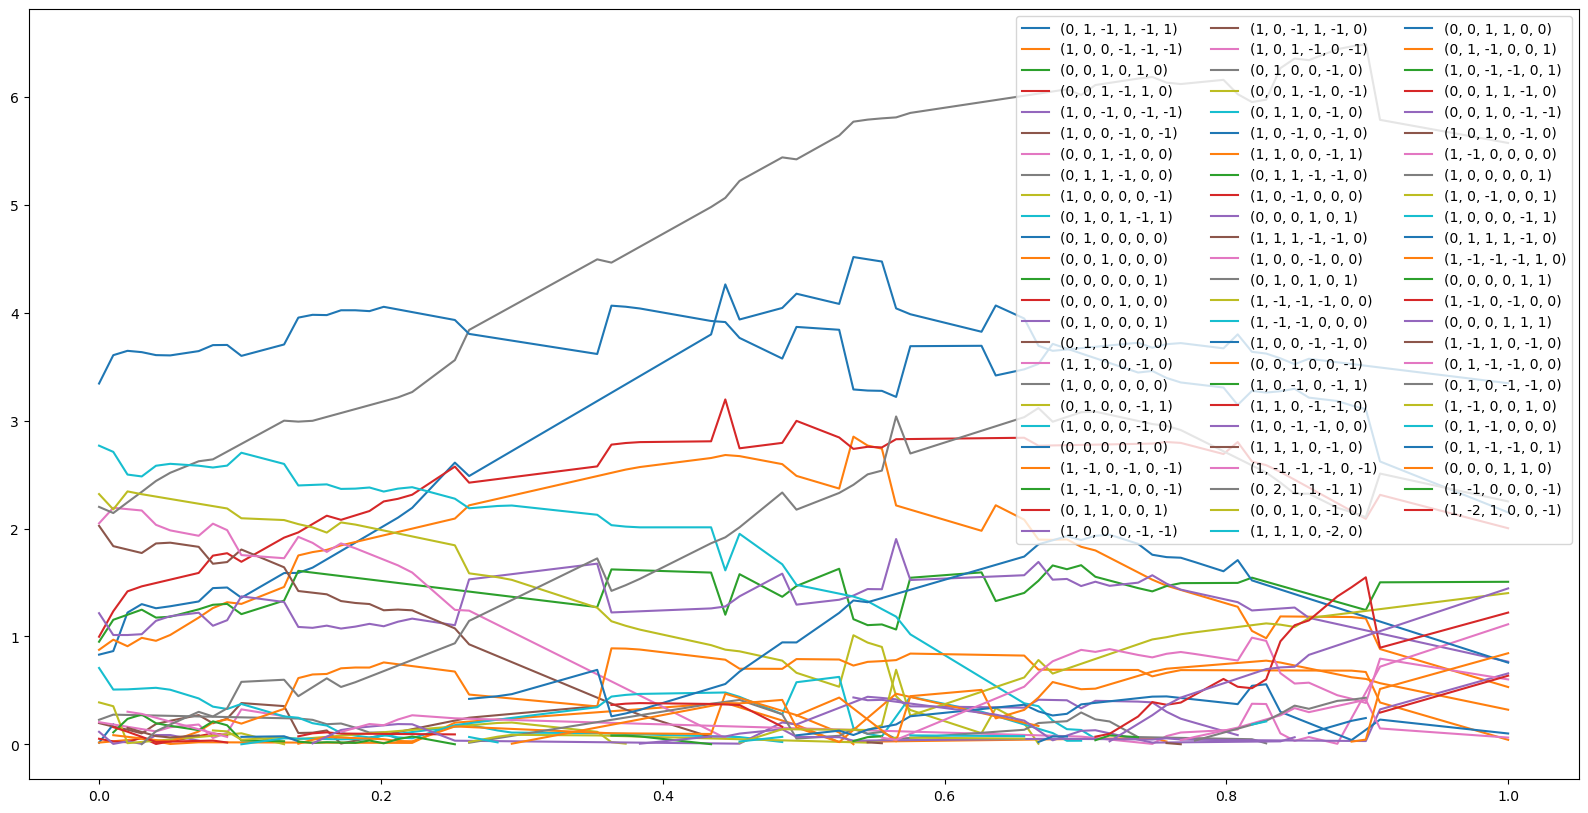

In [23]:
fig = plt.figure(figsize=(20,10))
for offset,(t,coef) in decomp.items():
    plt.plot(t,coef)
plt.legend(decomp.keys(),ncol=3)
savefig(fig,"Coefs_Vor4.pdf")

### 1.3 Case of a field of tensors

On the CPU, the decomposition time increases linearly with the number of tensors.
On the GPU, the decomposition runs on a single thread, and there are $2560$ of them on a nvidia $1080$ class card. 
Therefore time is rather insensitive to the number of tensors until that number is reached.

**Notes on the GPU implementation.**
The GPU based Voronoi decomposition is approximately $100$ times faster than the CPU based one (except on the first call on a given machine, where JIT compilation takes a little while). However, it is also less stable, since it uses single precision scalars. In order to address this issue, the GPU implementation is first run using single precision, and then using double precision for the matrices whose decomposition proved to be excessively inaccurate.

<!--- This needs to be sorted out. One possibility would be to make a second call using double precision for the few tensors which were not correctly decomposed. Another approach is to try debug the code.--->

<!---
**Note on CPU/GPU computation time**
Computation time is dominated ($90\%$) by the solution of a linear problem, with 15 variables and 36 constraints. 
Currently this is done using the following algorithm:

* Academic paper : Seidel, R. (1991), "Small-dimensional linear programming and convex hulls made easy", Discrete & Computational Geometry 6 (1): 423–434, doi:10.1007/BF02574699
* Source code : https://github.com/cgrushko/seidel-lp-solver

This algorithm appears not to be well adapted to the task at hand, since it is mostly intended for linear programs in dimension $<10$, and its complexity grows exponentially with the dimension. Also, the GPU seems not to like it (lots of branching).
--->

<!---In the current implementation, the GPU code appears to be quite slow, in addition to being less stable due to the use of single-precision floating point variables. A multi-threaded CPU implementation--->

In [24]:
def decomp_time(n):
    np.random.seed(42)
    D = MakeRandomTensor(6,(n,))
    start = time.time()
    coefs,offsets = VoronoiDecomposition(D)
    print(f"Decomposition of {n} matrices completed in {time.time()-start} seconds")
    print("Tensor shape: ",D.shape,", max reconstruction error : ",np.max(np.abs(D-Reconstruct(coefs,offsets))))
#    assert allclose(D,Reconstruct(coefs,offsets))
    return D,coefs,offsets

In [25]:
decomp_time(10);

Decomposition of 10 matrices completed in 0.011260032653808594 seconds
Tensor shape:  (6, 6, 10) , max reconstruction error :  1.7763568394002505e-14


In [26]:
decomp_time(100);

Decomposition of 100 matrices completed in 0.06769394874572754 seconds
Tensor shape:  (6, 6, 100) , max reconstruction error :  1.6697754290362354e-13


In [27]:
decomp_time(1000);

Decomposition of 1000 matrices completed in 0.6217541694641113 seconds
Tensor shape:  (6, 6, 1000) , max reconstruction error :  3.2152058793144533e-13


On the GPU, decomposition time should be mostly insensitive to $n\leq 2500$, and scale linearly with $n$ beyond that limit. 

<!---
TODO : investigate this GPU failure, which is probably due to roundoff errors.
Decomposition of 10000 matrices completed in 73.4375216960907 seconds
Tensor shape:  (6, 6, 10000) , max reconstruction error :  7.562082901426454

CPU does not fail here.
Decomposition of 10000 matrices completed in 340.8524580001831 seconds
Tensor shape:  (6, 6, 10000) , max reconstruction error :  5.329070518200751e-13
--->

In [28]:
if large_instances: decomp_time(10000);

In [29]:
if large_instances: decomp_time(50000)

## 2. Under the hood, Voronoi's first reduction 

**Voronoi's first reduction.** Voronoi associates to each positive quadratic form, defined by a positive definite matrix $D$, the following optimization problem
$$
    V(D) = \min_M \mathrm{Tr}(D M)
$$
where $M$ is a symmetric matrix, subject to the following linear constraints: for all $e \in Z^d \setminus \{0\}$
$$
    <e,M e> \geq 2.
$$
The set $\mathcal M$ of matrices $M$ obeying these constraints is known as Ryskov's polyhedron. (The constant $2$ in the above equation is customary, but may of course be replaced with an arbitary positive constant, such as $1$.)

**Dual linear program.** Voronoi's first reduction is a well posed linear program, hence it admits a dual linear program, namely
$$
    \max_\lambda \sum_{e \in Z^d\setminus\{0\}} \lambda(e)
$$
where $\lambda : Z^d\setminus\{0\} \to R$ is constrained to be non-negative, and to obey 
$$
    \sum_{e \in Z^d\setminus\{0\}} \lambda(e) e e^T = D.
$$

**Computation of the decomposition.**
We numerically solve Voronoi's first reduction, using a *highly precomputed* simplex-like method. 
By precomputation, we mean that all the vertices of Ryskov's polyhedron are known in advance, as well as their connectivity. Indeed, a famous result of Voronoi states that Ryskov's polyhedron admits only finitely many classes of vertices, up to arithmetic equivalence (linear changes of variables with integer coordinates).

From the solution to the primal linear program, Voronoi's first reduction, we can then deduce a solution to the dual linear program, namely the matrix decomposition that is of interest to us. 

The primal linear program admits a unique solution, for generic $D$. However, the dual linear program usually has several solutions, because some of the vertices of Ryskov's polyhedron are degenerate.

### 2.1 Voronoi's perfect forms

Ryskov's polyhedron in dimension $d=6$ admits $7$ classes of vertices, up to arithmetic equivalence, see above. They are described in detail in the following reference:
* Barnes, E. S. (1957). The complete enumeration of extreme senary forms. Philosophical Transactions of the Royal Society of London. Series a, Mathematical and Physical Sciences, 249(969), 461–5

In [30]:
perfect_forms6 = expand_symmetric_matrix(np.array([
 [2. ,1. ,2. ,1. ,1. ,2. ,1. ,1. ,1. ,2. ,1. ,1. ,1. ,1. ,2. ,1. ,1. ,1. ,1. ,1. ,2. ],
 [2. ,0. ,2. ,1. ,1. ,2. ,1. ,1. ,1. ,2. ,1. ,1. ,1. ,1. ,2. ,1. ,1. ,1. ,1. ,1. ,2. ],
 [2. ,0. ,2. ,0. ,1. ,2. ,1. ,1. ,1. ,2. ,1. ,1. ,1. ,1. ,2. ,1. ,1. ,1. ,1. ,1. ,2. ],
 [2. ,0.5,2. ,1. ,1. ,2. ,1. ,1. ,0.5,2. ,1. ,1. ,1. ,1. ,2. ,1. ,1. ,1. ,1. ,0.5,2. ],
 [2. ,0.5,2. ,1. ,1. ,2. ,1. ,1. ,0.5,2. ,1. ,1. ,0.5,0.5,2. ,1. ,1. ,0.5,0.5,0.5,2. ],
 [2. ,0.5,2. ,1. ,1. ,2. ,1. ,1. ,0.5,2. ,1. ,1. ,0.5,0.5,2. ,1. ,1. ,1. ,1. ,1. ,2. ],
 [2. ,0. ,2. ,0.5,1. ,2. ,1. ,1. ,1. ,2. ,1. ,0.5,1. ,1. ,2. ,0.5,1. ,1. ,0.5,0. ,2. ]]).T
)

Perfect forms are beautiful mathematical objects, and each of these matrices has a particular story to tell.
In particular, the form of index two:
* Defines the densest periodic ellipsoid packing in dimension 6.
* Defines the root lattice of the lie group E6.
* Is a highly degenerate vertex of Ryskov's polyhedron, with 36 pairs of vectors $\pm e \in Z^6 \setminus \{0\}$ saturating the constraint $<e,M e> = 2$. It also has $38124$ neighbor vertices on the skeleton of Ryskov's polyhedron, whose complete list is included in the C++ source code of the agd library.

In [31]:
np.linalg.det(np.moveaxis(perfect_forms6,-1,0))

array([7.      , 4.      , 3.      , 5.484375, 3.796875, 5.0625  ,
       5.359375])

In [32]:
perfect_forms6[:,:,2]

array([[2., 0., 0., 1., 1., 1.],
       [0., 2., 1., 1., 1., 1.],
       [0., 1., 2., 1., 1., 1.],
       [1., 1., 1., 2., 1., 1.],
       [1., 1., 1., 1., 2., 1.],
       [1., 1., 1., 1., 1., 2.]])

On the other hand, the perfect form of index $0$ admits counterparts in all dimensions. It is optimal (up to arithmetic equivalence) for a matrix $D$ if, and only if, $D$ admits an obtuse superbase. See the notebook on [Selling's reduction](TensorSelling.ipynb).

It is a non degenerate vertex of Ryskov's polyhedron, and thus has $21 = \mathrm{dim}(S_6)$ such vector pairs $\pm e\in Z^d$ saturating the constaint $<e,Me>\geq 2$, and $21$ neighbor vertices on the skeleton of Ryskov's polyhedron. 

In [33]:
perfect_forms6[:,:,0]

array([[2., 1., 1., 1., 1., 1.],
       [1., 2., 1., 1., 1., 1.],
       [1., 1., 2., 1., 1., 1.],
       [1., 1., 1., 2., 1., 1.],
       [1., 1., 1., 1., 2., 1.],
       [1., 1., 1., 1., 1., 2.]])

### 2.2 Computing Voronoi's first reduction

In order to obtain the full Voronoi decomposition, we use the split argument.

<!---
**Note on the retry64_tol argument.** In this mode, with the 
--->

In [34]:
np.random.seed(42)
D = MakeRandomTensor(6)
a,vertex,objective,weights,offsets = VoronoiDecomposition(D,steps='Split')

In this example, the second perfect form is optimal, up to arithmetic equivalence.

In [35]:
vertex # Index of the optimal perfect form

array(2)

The linear change of variables, defining the arithmetic equivalence, is returned as well.

In [36]:
a

array([[ 0.,  1.,  0., -1., -1.,  0.],
       [ 1.,  0.,  0., -1.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  0.,  0.],
       [ 0., -1., -1.,  1.,  1., -1.],
       [ 0.,  0.,  0.,  1.,  1.,  0.],
       [-1.,  0.,  0.,  1.,  0.,  1.]])

And the optimal matrix for Voronoi's decomposition is thus obtained as follows.

In [37]:
def dot_tADA(A,D):
    return lp.dot_AA(lp.dot_AA(lp.transpose(A),D),A)

In [38]:
M = dot_tADA(a,perfect_forms6[:,:,vertex])

In [39]:
M

array([[ 2., -1.,  0., -1.,  1., -1.],
       [-1.,  2.,  1.,  0., -2.,  1.],
       [ 0.,  1.,  2., -1., -2.,  1.],
       [-1.,  0., -1.,  2.,  1.,  0.],
       [ 1., -2., -2.,  1.,  4., -1.],
       [-1.,  1.,  1.,  0., -1.,  2.]])

The value of Voronoi's first reduction is also, by Kantorovitch duality, (twice) the sum of the coefficients of the decomposition of $D$.

In [40]:
lp.trace(lp.dot_AA(D,M)) # Value of primal linear program

48.6937132003662

In [41]:
objective # Common value of the primal and dual linear programs

array(48.6937132)

In [42]:
2*np.sum(weights) # Value of dual linear program (matrix decomposition)

48.69371320036622

The offsets involved in the decomposition of $D$ saturate the constraint $<e, M e> \geq 2$.

In [43]:
lp.dot_VAV(offsets,np.expand_dims(M,axis=-1),offsets)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2.])

### 2.3 Most common optimal form

Not all perfect forms are equal. The form of index two takes is optimal most of the time ($90\%$ of cases), up to arithmetic equivalence, whereas the form of index zero is rarely optimal. These two forms are discussed above.

In [44]:
np.random.seed(42)
D = MakeRandomTensor(6,(20000 if large_instances else 1000,))
a,vertex,objective,weights,offsets = VoronoiDecomposition(D,steps='Split')

In [45]:
index,counts = np.unique(vertex,return_counts=True)
print(f"Found optimal forms {index} with counts {counts},\n hence frequency {counts/vertex.size}")

Found optimal forms [1 2 3 4 5 6] with counts [ 83 890  10   5  11   1],
 hence frequency [0.083 0.89  0.01  0.005 0.011 0.001]


## 3. Voronoi's first reduction in lower dimensions 

The theory descibed in the previous section for six dimensions applies as well in all other dimensions. We briefly reproduce similar results in dimension $2$, $3$, $4$ and $5$. There is a single perfect form in dimension $2$ and $3$. In other words, all vertices of Ryskov's polyhedron are arithmetically equivalent in these dimensions.

In [46]:
perfect_forms2 = expand_symmetric_matrix(np.array([
    [2.,1.,2.]
]).T)
perfect_forms3 = expand_symmetric_matrix(np.array([
    [2.,1.,2.,1.,1.,2.]
]).T)
perfect_forms4 = expand_symmetric_matrix(np.array([
    [2, 1, 2, 1, 1, 2, 0, 1, 1, 2],
    [2, 1, 2, 1, 1, 2, 1, 1, 1, 2.]
]).T)
perfect_forms5 = expand_symmetric_matrix(np.array([
    [2,1,2,1,1,2,1,1,1,2,0,1,1,1,2],
    [2,1,2,1,1,2,1,1,1,2,1,1,1,1,2],
    [2,0.5,2,0.5,0.5,2,-1,-1,-1,2,-1,-1,-1,0.5,2]
]).T)

In [47]:
perfect_forms = (None,None,perfect_forms2,perfect_forms3,perfect_forms4,perfect_forms5,perfect_forms6)

In [48]:
np.random.seed(42)
for d in range(2,7):
    if d<=3 and VoronoiDecomposition.default_mode == 'gpu_transfer': continue # low dim not implemented on GPU
    print(f'\n---- Dimension {d} ----')
    D = MakeRandomTensor(d)
    a,vertex,objective,weights,offsets = VoronoiDecomposition(D,steps='Split')
    print(f"Decomposed matrix : \n {D}")
    
    M = dot_tADA(a,perfect_forms[d][:,:,vertex])
    print(f"Optimal vertex of Ryskov's polyhedron has class {vertex}, and value : \n {M} ")
    
    print(f"Common value of the primal and dual linear programs : {objective}")
    print(objective,2*weights.sum(),lp.trace(lp.dot_AA(D,M)))
    assert allclose(objective,2*weights.sum())
    assert allclose(objective,lp.trace(lp.dot_AA(D,M)))

    print(f"Minimal weight {np.min(weights)} (must be non-negative)")
    assert np.allclose(D,Reconstruct(weights,offsets))
    assert np.all(weights>=0)

    offset_norms = lp.dot_VAV(offsets,np.expand_dims(M,axis=-1),offsets)
    print(f"Offset norms w.r.t optimal vertex {offset_norms} (must be two)")

    if d<=3: continue
    nTest=1000
    D = MakeRandomTensor(d, (nTest,))
    a,vertex,objective,weights,offsets = VoronoiDecomposition(D,steps='Split')

    index,counts = np.unique(vertex,return_counts=True)
    print(f"\nReduced {nTest} random positive definite matrices.")
    print(f"Found optimal forms {index} with counts {counts},\nhence frequency {counts/vertex.size}")


---- Dimension 2 ----
Decomposed matrix : 
 [[0.81647351 0.91777115]
 [0.91777115 2.48898508]]
Optimal vertex of Ryskov's polyhedron has class 0, and value : 
 [[ 6. -3.]
 [-3.  2.]] 
Common value of the primal and dual linear programs : 4.370184339584079
4.370184339584079 4.370184339584078 4.370184339584079
Minimal weight 0.10129763611014375 (must be non-negative)
Offset norms w.r.t optimal vertex [2. 2. 2.] (must be two)

---- Dimension 3 ----
Decomposed matrix : 
 [[ 1.06841485 -0.08963958 -0.06552819]
 [-0.08963958  0.70200555 -0.73715916]
 [-0.06552819 -0.73715916  3.05670529]]
Optimal vertex of Ryskov's polyhedron has class 0, and value : 
 [[2. 2. 1.]
 [2. 6. 3.]
 [1. 3. 2.]] 
Common value of the primal and dual linear programs : 7.549703933010012
7.549703933010012 7.549703933010017 7.549703933010017
Minimal weight 0.035153608391365165 (must be non-negative)
Offset norms w.r.t optimal vertex [2. 2. 2. 2. 2. 2.] (must be two)

---- Dimension 4 ----
Decomposed matrix : 
 [[ 4.685


Reduced 1000 random positive definite matrices.
Found optimal forms [1 2 3 4 5 6] with counts [ 81 894   3  10  11   1],
hence frequency [0.081 0.894 0.003 0.01  0.011 0.001]
